# 快速傅立叶变换（FFT）在整数乘法中的应用

在上一篇博文中，我们谈到了一种利用分治法优化整数乘法的算法，它的时间复杂度约为$O(n^{1.59})$，而本文将介绍另一种基于快速傅立叶变换（Fast Fourier Transform, FFT）的整数乘法，它的时间复杂度更低，为$O(n\log n)$。这个方法将整数乘法和多项式乘法联系起来，而后者可以利用快速傅立叶变换进行计算。值得注意的是，在快速傅立叶变换的实现算法中，我们将再次看到分治思想的身影。

## 整数乘法转化为多项式乘法

首先，我们建立整数乘法和多项式乘法的联系。举一个简单的例子，假设$x=123456$。若以十为底，则可以将它写成：
$$
123456 = 6 \times 10^0 + 5 \times 10^1 + 4 \times 10^2 + 3 \times 10^3 + 2 \times 10^4 + 1 \times 10^5,
$$
所以，整数123456可以和多项式$6 + 5x + 4x^2 + 3x^3 + 2x^4 + x^5$对应，而该多项式又可以由它的系数向量$[6, 5, 4, 3, 2, 1]$表示。它们的转换代码如下所示。

In [1]:
def int_to_poly(x, base=10):
    """
    Args:
        x: int, integer to be represented as a polynomial
        bast: int
    Returns:
        a list containing the coefficients of the corresponding polynomial
    """
    if x == 0:
        return [0]
    x = abs(x)
    p = []
    while x > 0:
        x, r = divmod(x, base)
        p.append(r)
    return p

In [2]:
int_to_poly(123456, base=10)

[6, 5, 4, 3, 2, 1]

In [3]:
def poly_to_int(p, base=10):
    """
    Args:
        p: list, polynomial representation of an integer
        base: int
    Returns:
        the integer represented by p
    """
    n = len(p) 
    return sum([d * base ** (n - 1 - i) for i, d in enumerate(p[::-1])])

In [4]:
poly_to_int([6, 5, 4, 3, 2, 1], base=10)

123456

另外，将整数乘法和多项式乘法都写成竖式，可以发现它们是类似的：

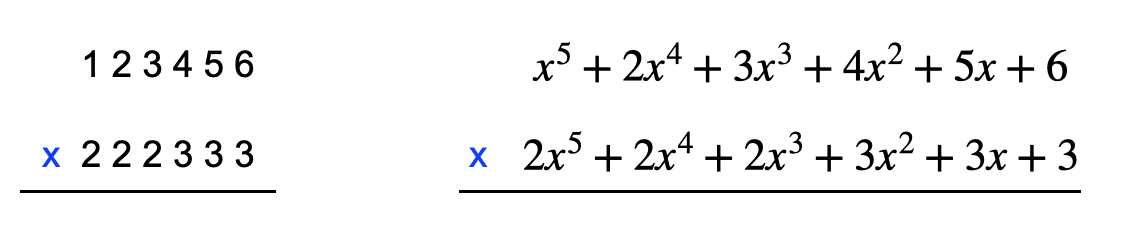

所以，接下来我们只需要考虑多项式之间的乘法即可。

## FFT视角下的多项式乘法

假设我们有两个$d$次多项式$A(x)=a_0 + a_1 x + a_2 x^2 + \cdots + a_d x^d$和$B(x)=b_0 + b_1 x + b_2 x^2 + \cdots + b_d x^d$，它们的乘积是一个$2d$次多项式：
$$
C(x)=c_0 + c_1x + c_2x^2 + \cdots + c_{2d} x^{2d},
$$
其中$c_k = a_0b_k + a_1b_{k-1} + \cdots a_kb_0 = \sum_{i=0}^{k}a_k b_{k-i}$。

关于多项式$C$的表示方法，除了可以用一个$2d+1$维的系数向量$[c_0, c_1, \cdots, c_{2d}]$表示以外，还可以用它在$2d+1$个点上的取值来表示，即
$$
C(x_0), C(x_1), \cdots, C(x_{2d})
$$
唯一决定了$C$，这叫做多项式的值表示法（value representation）。我们希望尽可能快速地计算出这些值，然后再将$C$还原成系数表示的形式。注意到$C(x_k) = A(x_k) B(x_k)$，所以问题的关键是计算$A(x_k)$和$B(x_k)$，也就是如何将一个多项式从系数表示法转换成值表示法，这个过程称为evaluation，而前面提到的从值表示法还原成系数表示法则称为interpolation。

多项式乘法的算法如下：

```
算法1：多项式乘法
--------------
输入：d次多项式 A(x) 和 B(x)
输出：乘积C = A ⋅ B

Selection: 
    挑选点x_0, x_1, x_2, ⋯, x_(n-1) ( n >= 2d + 1)
Evaluation:
    计算 A(x_0), A(x_1), ⋯, A(x_(n-1))和B(x_0), B(x_1), ⋯, B(x_(n-1))
Multiplication:
    计算 C(x_k)=A(x_k)B(x_k), k = 0, ⋯, n - 1
Interpolation: 
    还原 C(x) = c_0 + c_1x + ⋯ + c_(2d)x^(2d)
```

注意，这里取超过$2d+1$个点看似是浪费时间，但是不影响结果，并且接下来会看到，通过取超过$2d+1$的最小的2的幂次个点可以大大简化计算。

### 1. Evaluation

在Evaluation阶段，我们的目标是快速计算$n$个值：$A(x_0), A(x_1), A(x_{n-1})$。为了达成这个目标，我们必须挑选**便于计算**或者能**重复利用已知计算结果**的点。那么，多项式有什么特性吗？仔细思考后不难发现，偶数次幂的结果对于$\pm x$都相同，而奇数次幂则正好相反。于是，一个自然而然的想法是挑选$n$个正负配对的点
$$
\pm x_0, \pm x_1, \cdots, \pm x_{n/2-1},
$$
这样计算$A(x_i)$和$A(-x_i)$时就存在大量重复之处，我们只需计算一次偶数次幂和奇数次幂即可。

举一个例子，假设$n=8$, $A(x) = 3 + 4x + 6x^2 + 2x^3 + x^4 + 10x^5 - 2x^6 + 2 x^7$，于是

\begin{align}
A(x) &= (3 + 6x^2 + x^4 - 2 x^6) + x(4 + 2x^2 + 10x^4 +2x^6) \\
&= A_e(x^2) + x A_o(x^2),
\end{align}

\begin{align}
A(-x) &= (3 + 6x^2 + x^4 - 2 x^6) - x(4 + 2x^2 + 10x^4 +2x^6) \\
&= A_e(x^2) - x A_o(x^2).
\end{align}

这里$A_e(x) = 3 + 6x + x^2 -2x^3$，$A_o(x)=4 + 2x + 10x^2 + 2x^3$。

可以看到，通过奇偶分项既可以降低次数，又可以重复利用$A_e$和$A_o$的计算结果。分拆后又合并，这不就是分治思想吗？没错，Evaluation阶段的核心思想就是分治！

上面的讨论告诉我们挑选的点要正负配对（保证$x^2$相同），这样只需要计算次数仅为原来一半的$A_e$和$A_o$就可以得到$A(x)$和$A(-x)$。为了能对$A_e$和$A_o$做同样的操作，我们必须保证挑选的点**经过平方以后仍然要是正负配对的**！也就是说，$x^4$要相同，而配对组数只有原来的一半（因为次数降低，所需要的点只有原来的一半），如下图所示：

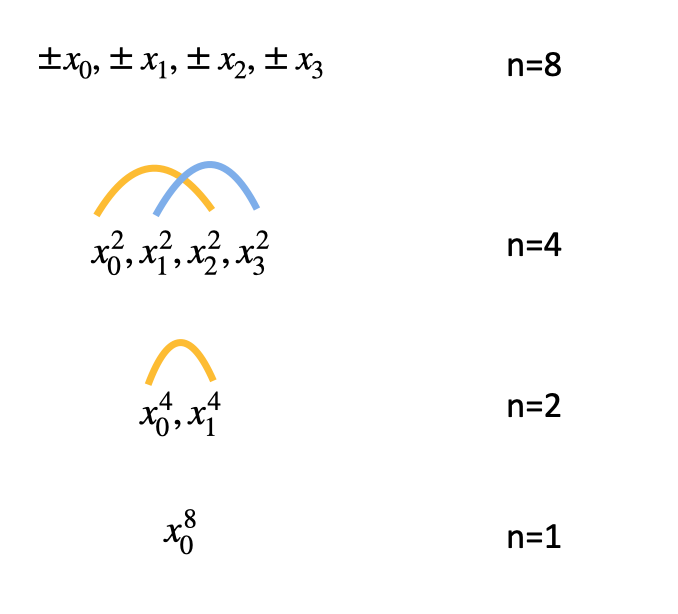

上面的图告诉我们，假设一开始有4组正负匹配，经过平方后得到2组正负匹配，再平方得到1组正负匹配，最后一次平方得到一个数，也就是递归的出口（base case）。接下来考虑base case要取什么值好。首先排除0，因为每一轮都有正负匹配的要求，如果用了0，那每一轮的点都是0了。而除了0以外，最简单的数就是1了，没错，就是它了！我们取最后一个点$x_0^8$为1，则$x_0^4$和$x_1^4$为1的二次方根，一路往上推，$x_0^2, x_1^2, x_2^2, x_3^2$为1的四次方根，$\pm x_0, \pm x_1, \pm x_2, \pm x_3$为1的八次方根，所以我们一开始要找的8个点就是$z^8=1$的根！推广到任意情形，即找$z^n=1$的根。

$z^n = 1$的$n$个根叫做“complex nth roots of unity”，依次为$1, \omega, \omega^2, \cdots, \omega^{n-1}$，其中，$\omega = e^{2\pi i /n}$。如果一开始$n$是2的幂次，那么在接下来的每一轮递归会依次得到"$(n/2^k)$-th root of unity", $k=1, 2, 3, \cdots$，这些点均正负匹配，可以利用分治法快速计算它们的值。这就是快速傅立叶变换(FFT)。

FFT变换算法如下：

```
算法2: FFT
----------
输入：多项式A(x)的系数，该多项式次数<=n-1, n为2的幂次；
     omega, n-th root of unity
输出：值表达形式 A(omega^0), A(omega^1), ... , A(omega^(n-1))

if omega = 1: return A(1)

拆分A(x) = A_e(x^2) + x A_o(x^2)
调用FFT(A_e, omega^2)得到 A_e在omega的偶次幂处取值
调用FFT(A_o, omega^2)得到 A_o在omega的偶次幂处取值

for j = 0 to n - 1:
    计算 A(omega^j) = A_e(omega^2j) + omega^j A_o(omega^2j)
    
return A(omega^0), A(omega^1), ..., A(omega^(n-1))
```

FFT是一种分治算法，假设它的时间为$T(n)$，则
$$
T(n) = 2 T(n / 2) + O(n).
$$

可见它的时间复杂度为$O(n \log n)$。

### 2. Interpolation

通过FFT，我们将多项式从系数表达转换为值表达（Evaluation）：
$$
<\text{值}> = \text{FFT}(<\text{系数}>, \omega).
$$

反过来从值表达转换为系数表达（Interpolation）也很简单：
$$
<系数> = \frac{1}{n}\text{FFT}(<值>, \omega^{-1}).
$$

FFT既可以用于evaluation，又可以用于interpolation，非常的巧妙。为了证明interpolation的计算式是正确的，我们将从矩阵观点来看看FFT究竟做了哪些操作。

在evaluation阶段，我们其实是将系数向量$[a_0, a_1, \cdots, a_{n-1}]$做了以下线性变换得到值向量$[A(x_0), A(x_1), \cdots, A(x_{n-1}]$:

$$
\left[\begin{array}{c}
A\left(x_{0}\right) \\
A\left(x_{1}\right) \\
\vdots \\
A\left(x_{n-1}\right)
\end{array}\right]=\left[\begin{array}{ccccc}
1 & x_{0} & x_{0}^{2} & \cdots & x_{0}^{n-1} \\
1 & x_{1} & x_{1}^{2} & \cdots & x_{1}^{n-1} \\
& & \vdots & \\
1 & x_{n-1} & x_{n-1}^{2} & \cdots & x_{n-1}^{n-1}
\end{array}\right]\left[\begin{array}{c}
a_{0} \\
a_{1} \\
\vdots \\
a_{n-1}
\end{array}\right]，
$$

中间的矩阵$M$称为Vandermonde矩阵，它有如下性质：当$x_0, x_1, \cdots, x_{n-1}$相异时可逆。

在Interpolation阶段，需要计算$M^{-1}$。这里的关键点是，由于我们选取的点（n-th root of unity）的特殊性使得这个逆矩阵的计算变得非常容易。

将我们选取的点$1, \omega, \omega^2, \cdots, \omega^{n-1}$代入$M$：
$$
M = M_{n}(\omega)=\left[\begin{array}{ccccc}
1 & 1 & 1 & \cdots & 1 \\
1 & \omega & \omega^{2} & \cdots & \omega^{n-1} \\
1 & \omega^{2} & \omega^{4} & \cdots & \omega^{2(n-1)} \\
& & \vdots \\
1 & \omega^{j} & \omega^{2 j} & \cdots & \omega^{(n-1) j} \\
& & \vdots & \\
1 & \omega^{(n-1)} & \omega^{2(n-1)} & \cdots & \omega^{(n-1)(n-1)}
\end{array}\right].
$$

**Claim:**
$$
M_n(\omega)^{-1} = \frac{1}{n} M_n(\omega^{-1}).
$$
证明过程主要分两步，首先证明$M$的列两两正交，于是$MM^* = M^*M = nI$；第二步计算$M^*$，主要用到$\omega$的共轭 $\bar{\omega} = \omega^{-1}$，所以$M^* = M_n(\omega^{-1})$。

### 3. 从矩阵角度近距离观察FFT

接下来让我们从矩阵角度观察FFT并改写算法2。将矩阵$M_n(\omega)$的偶数列和奇数列重新排序，偶数列放到最前列，相应地，系数向量$a$的偶数位也放到最前列。此时可以将$M_n(\omega)$划分成四块：偶数列分为上下相等的两块，奇数列分为上下相反的两块，如下图所示。这里需要用到下面两个式子：
\begin{align}
\omega^{2k(j+n/2)} &= \omega^{2jk + nk}=\omega^{2jk}, \\
\omega^{(2k + 1)(j+n/2)} &= \omega^{2k(j+n/2)} \omega^{j+n/2} = \omega^{2jk} \cdot \omega{j} \cdot \omega^{n/2} = - \omega^j \omega^{2jk}.
\end{align}

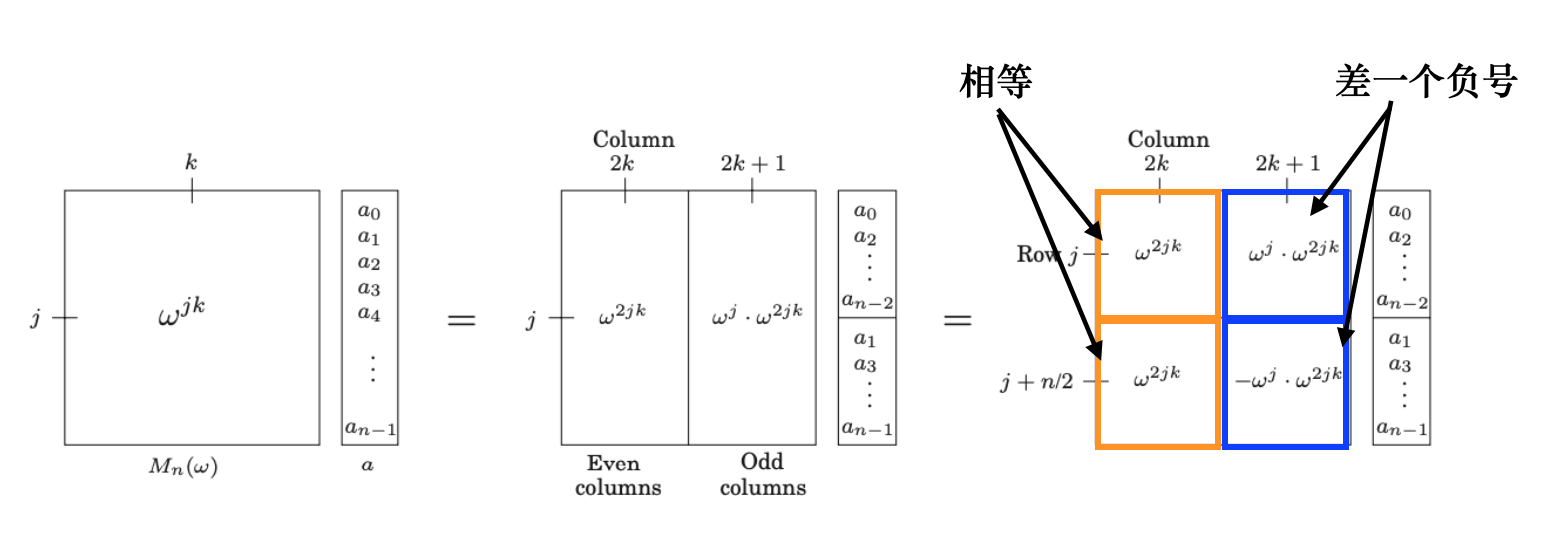

因为$\omega^{2jk} = (\omega^{jk})^2$，所以这四个小块其实都和$M_{n/2}(\omega^2)$有关，如下图所示：

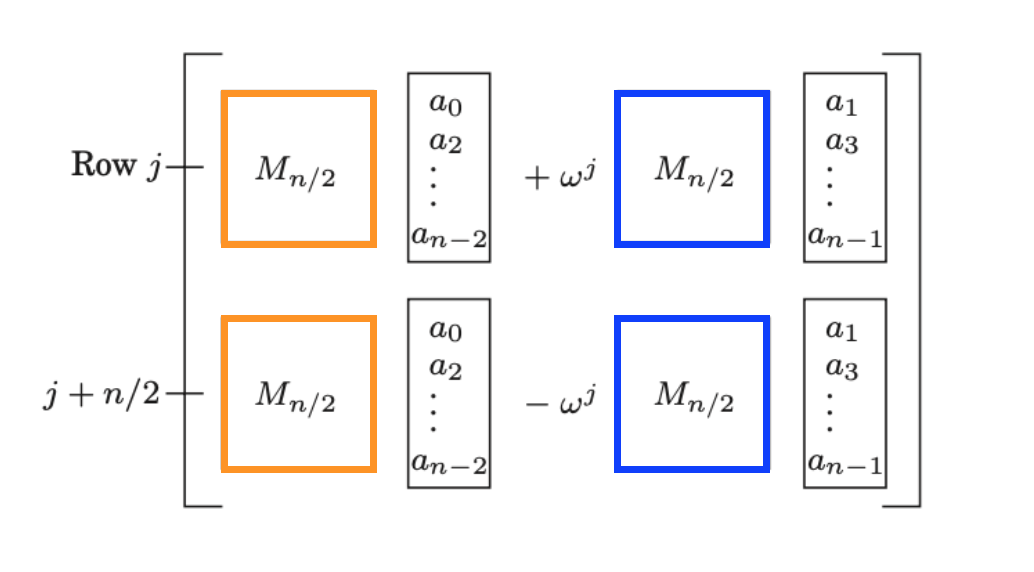

改写后的FFT算法2为：

```
算法2': FFT
----------
输入：多项式A(x)的系数向量a=(a_0, a_1, ..., a_(n-1))，该多项式次数<=n-1, n为2的幂次；
     omega, n-th root of unity
输出：M_n(omega)a

if omega = 1: return a
(s_0,   s_1, ...,  s_(n/2-1)) = FFT((a_0, a_2, ..., a_(n-2)), omega^2)
(s'_0, s'_1, ..., s'_(n/2-1)) = FFT((a_1, a_3, ..., a_(n-1)), omega^2)

for j = 0 to n/2 - 1:
    r_j         = s_j + omega^j s'_j
    r_(j + n/2) = s_j - omega^j s'_j
    
return (r_0, r_1, ..., r_(n-1))
```

### 代码

In [5]:
from cmath import exp
from math import pi

In [6]:
# A simple class to simulate n-th root of unity
# This class is by no means complete and is implemented
# merely for FFT and FPM algorithms
class NthRootOfUnity:
    
    def __init__(self, n, k = 1):
        self.k = k
        self.n = n

    def __pow__(self, other):
        if type(other) is int:
            n = NthRootOfUnity(self.n, self.k * other)
            return n

    def __eq__(self, other):
        if other == 1:
            return abs(self.n) == abs(self.k)

    def __mul__(self, other):
        return exp(2*1j*pi*self.k/self.n)*other

    def __repr__(self):
        return str(self.n) + "-th root of unity to the " + str(self.k)

    @property
    def th(self):
        return abs(self.n // self.k)

In [7]:
def FFT(A, omega):
    """
    The fast Fourier transform algorithm. The time complexity is O(n logn).
    
    Args:
        A: an array of integers of size n representing a polynomial
        omega: a root of unity
    Returns:
        [A(omega), A(omega^2), ..., A(omega^(n-1))]
    """
    if omega == 1:
        return [sum(A)]         # A(1)

    o2 = omega ** 2
    s = FFT(A[0::2], o2)        # even 
    s_prime = FFT(A[1::2], o2)  # odd
    r = [None] * omega.th
    for i in range(omega.th // 2):
        r[i]             = s[i] + omega ** i * s_prime[i]
        r[i+omega.th//2] = s[i] - omega ** i * s_prime[i]
    return r

In [8]:
def FPM(A, B):
    """
    The fast polynomial multiplication algorithm.
    
    Args:
        A, B: two arrays of integers representing polynomials, their length is in O(n).
    Returns:
        coefficient representation of AB.
    """
    n = 1 << (len(A) + len(B) - 2).bit_length()
    o = NthRootOfUnity(n)
    AT = FFT(A, o)
    BT = FFT(B, o)
    C = [AT[i] * BT[i] for i in range(n)]
    D = [round((a / n).real) for a in FFT(C, o ** -1)]
    while len(D) > 0 and D[-1] == 0:
        del D[-1]
    return D
    

In [9]:
def FFT_int_multiply(x, y):
    """
    Integer multiplication using Fast Fourier transform.
    
    Args:
        x, y: integers
    Returns:
        product of x and y
    """
    if x == 0 or y == 0:
        return 0
    elif (x > 0 and y > 0) or (x < 0 and y < 0):
        sign = 1
    else:
        sign = -1
    x = abs(x)
    y = abs(y)
    A = int_to_poly(x, base=10)
    B = int_to_poly(y, base=10)
    
    C = FPM(A, B)
    z = poly_to_int(C)
    return sign * z

**Reference**

1. [DPV *Algorithms* Chapter 2: The fast Fourier transform](http://algorithmics.lsi.upc.edu/docs/Dasgupta-Papadimitriou-Vazirani.pdf)
2. FFT代码参考：https://gist.github.com/berenoguz/f8bd037a82a23737a560d695cc9d6a0e